In [6]:
import sys
sys.path.append('../')

from model_runner import ModelRunner
from DBPN_copied import DBPN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
torch.cuda.empty_cache()
from torch import nn
from image_helper import ImageHelper
import image_patches
import os
import pandas as pd
from GaussianNoise import AddGaussianNoise

In [7]:
# DATASET_ROOT="../datasets/"
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"
# TRAIN_DATASET_NAME = "../datasets/set14/"
# VALIDATION_DATASET_NAME = "../datasets/Set5/"

In [8]:
PATCH_SIZE = 128 # 32 * 4
# PATCHES_PER_IMAGE_TRAIN = 20
PATCHES_PER_IMAGE_TRAIN = 30 ##
# PATCHES_PER_IMAGE_TRAIN = 50 ##
# PATCHES_PER_IMAGE_TRAIN = 4
# PATCHES_PER_IMAGE_VALIDATION = 4
PATCHES_PER_IMAGE_VALIDATION = 20 ##
# PATCHES_PER_IMAGE_VALIDATION = 1
# PATCHES_PER_IMAGE_TRAIN = 45
# PATCHES_PER_IMAGE_VALIDATION = 12 # 45 // 4

In [9]:
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [10]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [11]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


 87%|████████▋ | 2551/2920 [01:19<00:10, 33.55it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 2920/2920 [01:31<00:00, 31.88it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:10<00:00, 57.85it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training set has 87538 instances
Validation set has 12592 instances
CPU times: user 1h 20min 7s, sys: 14.3 s, total: 1h 20min 21s
Wall time: 1min 48s


In [ ]:
# image_helper = ImageHelper()
# image =  Image.open('../datasets/Set5/baby.png')
# image_tensor = image_helper.image_to_tensor(image)
# image_tensor = image_tensor + torch.randn(image_tensor.shape)*0.1
# image_helper.show_tensor_as_image(image_tensor)

In [14]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**6))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
CPU times: user 1.26 s, sys: 332 ms, total: 1.59 s
Wall time: 1.59 s


In [15]:
# image_helper = ImageHelper()
# i = 0
# for x, y in train_dataloader:
#     i += 1
#     if i > 2:
#         break
#     image_helper.show_tensor_as_image(x[0])
#     image_helper.show_tensor_as_image(y[0])
#     print(x.shape)
#     print(y.shape)
#     break

In [16]:
# The learning rate is initialized to 1e − 4 for all layers and decrease by a factor of 10 for every 5 × 105 iterations for total 106 iterations.
lr = 1e-3
model_betas = (0.9, 0.999)
device = torch.device('cuda:0')

# Total number of epochs
epochs = 25

model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_runner = ModelRunner()

# For optimization, we use Adam with momentum to 0.9 and weight decay to 1e−4.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=model_betas, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
#                               T_max = epochs, # Maximum number of iterations.
#                              eta_min = 1e-6) # Minimum learning rate.

In [17]:
%%time
model_runner.train(
    model=model,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer,
    epochs=epochs,
    scheduler=None,
    loss_fn=nn.MSELoss(),
    save_file_path='./DBPN-real-run-medium-dataset-no-noise-cuda-0.txt'
)


epoch 0
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████▉| 1367/1368 [07:07<00:00,  3.21it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 0.052176 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 0.004593 

Epoch: 0
Time: 454.2630410194397
Learning rate: 0.001
Train loss: 0.052175879908544526
Validation loss: 0.00459308534013202
Elapsed time: 454.2631244659424

epoch 1
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:07<00:00,  3.21it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 0.004695 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 0.004472 

Epoch: 1
Time: 454.26562237739563
Learning rate: 0.001
Train loss: 0.0046950264014194755
Validation loss: 0.004471802708177548
Elapsed time: 454.26570320129395

epoch 2
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:07<00:00,  3.20it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004580 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 0.004375 

Epoch: 2
Time: 454.20935249328613
Learning rate: 0.001
Train loss: 0.00458047830850997
Validation loss: 0.004375240013539923
Elapsed time: 454.2094404697418

epoch 3
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:07<00:00,  3.21it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:08<00:00,  3.19it/s]


Training Error: 
 Avg loss: 0.004534 



100%|██████████| 197/197 [00:23<00:00,  8.41it/s]


Validation Error: 
 Avg loss: 0.004333 

Epoch: 3
Time: 454.26623582839966
Learning rate: 0.001
Train loss: 0.004534316868711895
Validation loss: 0.004333146840988701
Elapsed time: 454.2663245201111

epoch 4
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:07<00:00,  3.21it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004517 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 0.004306 

Epoch: 4
Time: 454.0826337337494
Learning rate: 0.001
Train loss: 0.004516670502155845
Validation loss: 0.004306225138030908
Elapsed time: 454.0827453136444

epoch 5
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:07<00:00,  3.22it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004509 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 0.004318 

Epoch: 5
Time: 453.9308228492737
Learning rate: 0.001
Train loss: 0.004508980954942779
Validation loss: 0.004318392092449505
Elapsed time: 453.9309034347534

epoch 6
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:06<00:00,  3.22it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004508 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 0.004415 

Epoch: 6
Time: 453.74200439453125
Learning rate: 0.001
Train loss: 0.004507680215575999
Validation loss: 0.0044150077028738965
Elapsed time: 453.74208545684814

epoch 7
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:06<00:00,  3.22it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004522 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 0.004317 

Epoch: 7
Time: 453.36584091186523
Learning rate: 0.001
Train loss: 0.00452237643627586
Validation loss: 0.004316810085934582
Elapsed time: 453.36592841148376

epoch 8
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:05<00:00,  3.22it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:06<00:00,  3.21it/s]


Training Error: 
 Avg loss: 0.004534 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 0.004606 

Epoch: 8
Time: 452.6196265220642
Learning rate: 0.001
Train loss: 0.004533855509855757
Validation loss: 0.004606296648720497
Elapsed time: 452.61972212791443

epoch 9
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:05<00:00,  3.22it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:06<00:00,  3.21it/s]


Training Error: 
 Avg loss: 0.004519 



100%|██████████| 197/197 [00:23<00:00,  8.45it/s]


Validation Error: 
 Avg loss: 0.004335 

Epoch: 9
Time: 452.22634959220886
Learning rate: 0.001
Train loss: 0.004518891388736937
Validation loss: 0.004334833103333728
Elapsed time: 452.22642946243286

epoch 10
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:04<00:00,  3.24it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:05<00:00,  3.21it/s]


Training Error: 
 Avg loss: 0.004516 



100%|██████████| 197/197 [00:23<00:00,  8.48it/s]


Validation Error: 
 Avg loss: 0.004352 

Epoch: 10
Time: 451.3805501461029
Learning rate: 0.001
Train loss: 0.004516271195729803
Validation loss: 0.0043518334966351465
Elapsed time: 451.3806309700012

epoch 11
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [07:02<00:00,  3.26it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [07:03<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.004515 



100%|██████████| 197/197 [00:23<00:00,  8.50it/s]


Validation Error: 
 Avg loss: 0.004397 

Epoch: 11
Time: 448.80852818489075
Learning rate: 0.001
Train loss: 0.0045153713599255865
Validation loss: 0.004397441366826879
Elapsed time: 448.8086082935333

epoch 12
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:58<00:00,  3.28it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:59<00:00,  3.26it/s]


Training Error: 
 Avg loss: 0.004506 



100%|██████████| 197/197 [00:23<00:00,  8.52it/s]


Validation Error: 
 Avg loss: 0.004325 

Epoch: 12
Time: 445.57249903678894
Learning rate: 0.001
Train loss: 0.004506264859027561
Validation loss: 0.0043249493266862395
Elapsed time: 445.5725905895233

epoch 13
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.29it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004514 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004350 

Epoch: 13
Time: 443.09598875045776
Learning rate: 0.001
Train loss: 0.004513749494680274
Validation loss: 0.004349831278970096
Elapsed time: 443.09606885910034

epoch 14
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.29it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004497 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004330 

Epoch: 14
Time: 442.99546241760254
Learning rate: 0.001
Train loss: 0.004496577512901767
Validation loss: 0.004329530445109524
Elapsed time: 442.9955561161041

epoch 15
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  2.10it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004510 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Validation Error: 
 Avg loss: 0.004348 

Epoch: 15
Time: 442.76592206954956
Learning rate: 0.001
Train loss: 0.0045104681942080916
Validation loss: 0.0043476599739595
Elapsed time: 442.76600527763367

epoch 16
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004493 



100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Validation Error: 
 Avg loss: 0.004326 

Epoch: 16
Time: 442.49348974227905
Learning rate: 0.001
Train loss: 0.00449330523819118
Validation loss: 0.004325780823713329
Elapsed time: 442.49357056617737

epoch 17
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:55<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:56<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004497 



100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004326 

Epoch: 17
Time: 442.4215998649597
Learning rate: 0.001
Train loss: 0.0044966400948173385
Validation loss: 0.004326150634120393
Elapsed time: 442.42168831825256

epoch 18
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004490 



100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004351 

Epoch: 18
Time: 442.61025834083557
Learning rate: 0.001
Train loss: 0.004490468508260303
Validation loss: 0.0043506611556377315
Elapsed time: 442.6103398799896

epoch 19
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004492 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004346 

Epoch: 19
Time: 442.6188917160034
Learning rate: 0.001
Train loss: 0.0044915025745047394
Validation loss: 0.004345788484495984
Elapsed time: 442.61897134780884

epoch 20
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004490 



100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004320 

Epoch: 20
Time: 442.6880888938904
Learning rate: 0.001
Train loss: 0.004489754204609709
Validation loss: 0.004320335685840435
Elapsed time: 442.68817687034607

epoch 21
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:56<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004512 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Validation Error: 
 Avg loss: 0.004330 

Epoch: 21
Time: 442.46702098846436
Learning rate: 0.001
Train loss: 0.004511736954932717
Validation loss: 0.004330433704795761
Elapsed time: 442.4671006202698

epoch 22
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004476 



100%|██████████| 197/197 [00:23<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004394 

Epoch: 22
Time: 442.6434414386749
Learning rate: 0.001
Train loss: 0.004475580461660934
Validation loss: 0.004393508802298079
Elapsed time: 442.6435282230377

epoch 23
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004489 



100%|██████████| 197/197 [00:22<00:00,  8.57it/s]


Validation Error: 
 Avg loss: 0.004323 

Epoch: 23
Time: 442.62306809425354
Learning rate: 0.001
Train loss: 0.004489027296107164
Validation loss: 0.004323035630168214
Elapsed time: 442.62314796447754

epoch 24
-------------------------------
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Training on 87538 samples...
Batch size: 64
Number of batches: 1368
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


  0%|          | 0/1368 [00:00<?, ?it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0
Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|█████████▉| 1367/1368 [06:56<00:00,  3.30it/s]

Error loading image file: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30/patches/000658_patch/patch_8.png. Reason: file has size 0


100%|██████████| 1368/1368 [06:57<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004490 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]

Validation Error: 
 Avg loss: 0.004319 

Epoch: 24
Time: 442.52052664756775
Learning rate: 0.001
Train loss: 0.004490054942659315
Validation loss: 0.004319412137977401
Elapsed time: 442.52062940597534
CPU times: user 3h 5min 30s, sys: 1min 34s, total: 3h 7min 4s
Wall time: 3h 6min 34s


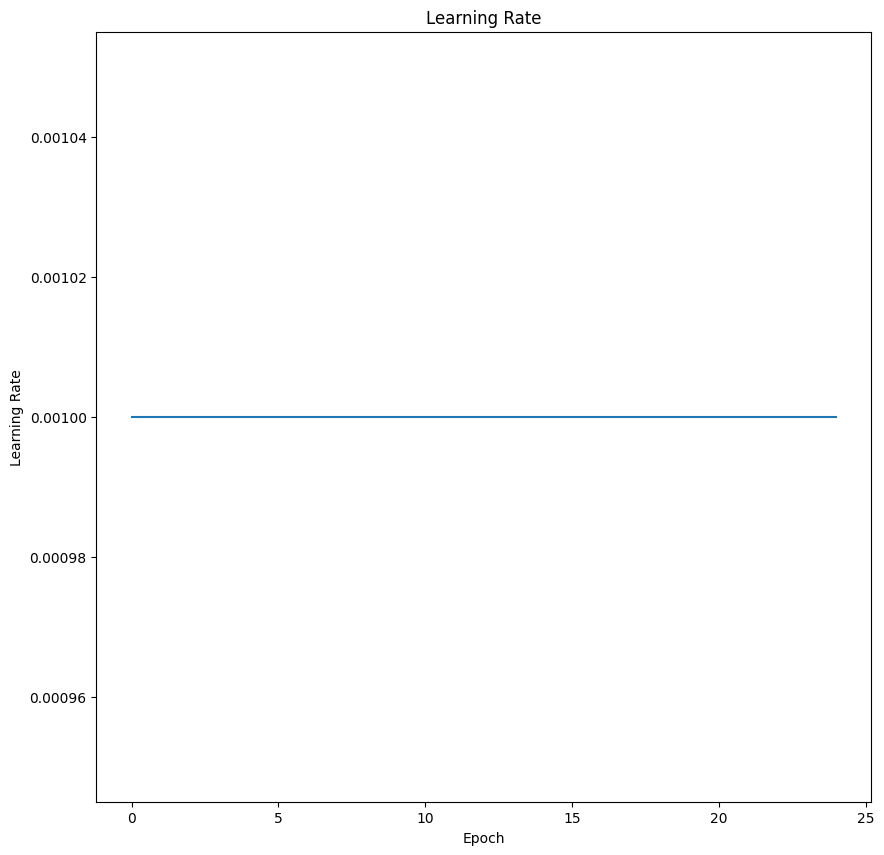

In [23]:
model_runner.plot_lr_from_df()

In [19]:
# model_runner.save_model_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-10-epoch=0-24.csv')
# model_runner.save_model_weights(model, '../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-10-epoch=0-24.pth')

In [25]:
df = model_runner.load_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-10-epoch=0-24.csv')
# model_runner.get_model_df()
df

,epoch,time,lr,train_loss,validation_loss
0,0,454.263040,0.001,0.052176,0.004593
1,1,454.265622,0.001,0.004695,0.004472
2,2,454.209352,0.001,0.004580,0.004375
3,3,454.266235,0.001,0.004534,0.004333
4,4,454.082633,0.001,0.004517,0.004306
5,5,453.930822,0.001,0.004509,0.004318
6,6,453.742004,0.001,0.004508,0.004415
7,7,453.365838,0.001,0.004522,0.004317
8,8,452.619626,0.001,0.004534,0.004606
9,9,452.226349,0.001,0.004519,0.004335


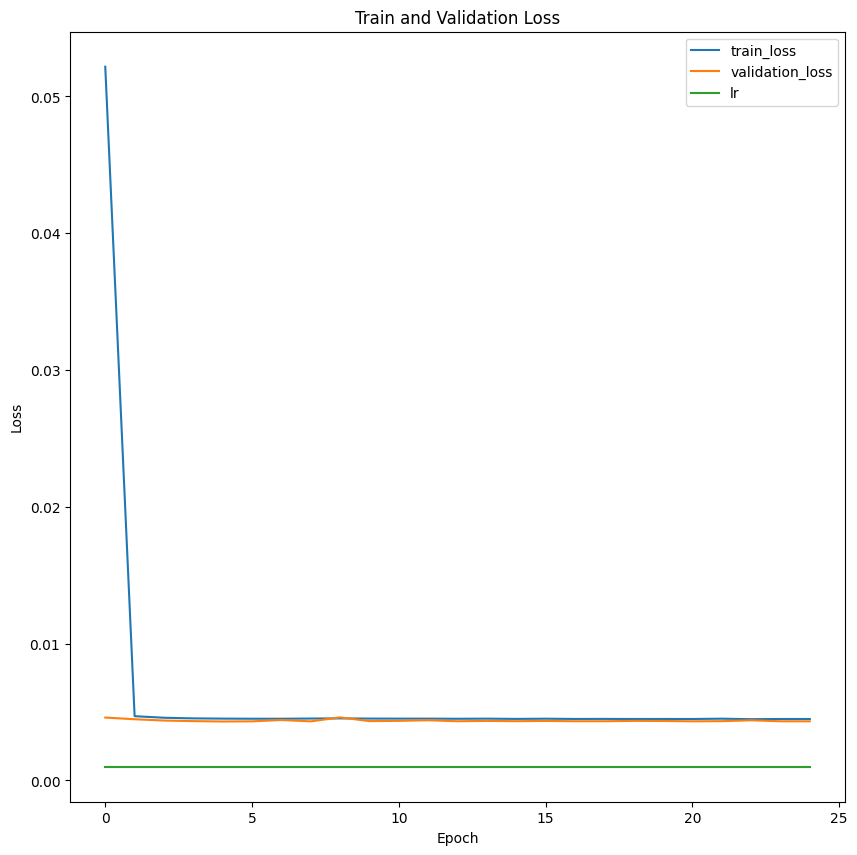

In [26]:
model_runner.plot_train_validation_loss_from_df()

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should_upsample MUST ONLY BE `TRUE` for SRCNN


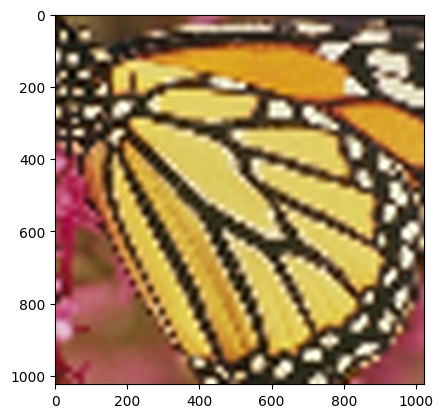

In [27]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)

In [28]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:02, 34.61it/s]
100it [00:01, 91.71it/s]


,PSNR,SSIM
DBPN,24.828545,0.652157
Bicubic,23.045410,0.632868


In [29]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN,24.850704,0.653421
Bicubic,23.045410,0.632868


In [29]:
model_2 = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_2.load_state_dict(torch.load('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-times-10-epoch=0-24.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model_2,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN,24.828545,0.652157
Bicubic,23.045410,0.632868


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should_upsample MUST ONLY BE `TRUE` for SRCNN


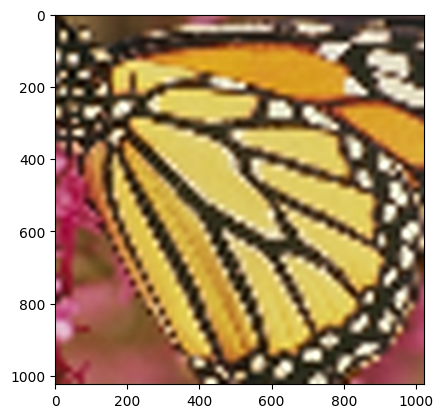

In [31]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model_2,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)